# Subsampling mocks
Using Mehdi's [code](https://github.com/mehdirezaie/LSSutils/blob/master/analysis/lssxcmb/scripts/subsample_mock.py).

In [1]:
# %matplotlib inline
import healpy as hp
import numpy as np
import fitsio as ft
import matplotlib.pyplot as plt
from glob import glob

In [2]:
def radec2hpix(nside, ra, dec):
    """ change ra,dec to HEALPix hpix with ring ordering """
    theta, phi = np.deg2rad(90.-dec), np.deg2rad(ra)
    hpix = hp.ang2pix(nside, theta, phi, nest=False)     
    return hpix

def project2hp(nside, mock, weight=None, return_hpix=False):
    """ count # of objects in HEALPix """
    ra = mock['RA']
    dec = mock['DEC']
    hpix = radec2hpix(nside, ra, dec)
    hpmap = np.bincount(hpix, weights=weight, minlength=12*nside*nside)
    if return_hpix:
        return hpmap, hpix
    else:
        return hpmap
    
def read_data(data, nside=256):
    d_ = data
    ng = ut.make_hp(nside, d_['hpix'], d_['label'])
    nr = ut.make_hp(nside, d_['hpix'], d_['fracgood'])
    mask = ut.make_hp(nside, d_['hpix'], 1.0) > 0.5
    syst = ut.make_hp(nside, d_['hpix'], np.log(d_['features'][:, 0]))
    return ng, nr, mask, syst
    
def normalize_selection_func(ngal_pred):
    # get nside from the selection function
    nside = hp.get_nside(ngal_pred)
    
    # normalize the selection function to [0, 1]
    good = ngal_pred>0
    vmin, vmax = np.percentile(ngal_pred[good], [0, 100])
    selection_func = np.zeros_like(ngal_pred)
    selection_func[good] = (ngal_pred[good]-vmin) / (vmax-vmin)
    return selection_func

def downsample(selection_func, mock):
    """ downsample a mock catalog with a given selection function """
    nside = hp.get_nside(selection_func)
    hpix = radec2hpix(nside, mock['RA'], mock['DEC'])
    prob = selection_func[hpix]    
    good = np.random.uniform(size=mock.size) < prob
    return mock[good]

def _desi_mock_filename(tracer='LRG', ph=0):
    """Collect the name of DESI Mocks in NERSC."""
    mock_dir='/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/'
    z_dic={'LRG':0.8,'ELG':1.1,'QSO':1.4}
    fname=f'{mock_dir}{tracer}/z{z_dic[tracer]:5.3f}/cutsky_{tracer}_z{z_dic[tracer]:5.3f}_AbacusSummit_base_c000_ph{ph:003d}.fits'
    return fname

def _selection_function_filename(tracer='LRG', ind=0):
    """Collect selection function obtained from NN."""
    tracer = tracer.lower() # after testing make a directory by tracer
    fname=f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_{ind}.hp256.fits'
    return fname

In [3]:
# read the mock catalog and selection function (obtained from real data)
mock_name = _desi_mock_filename(tracer='LRG', ph=0)
mock, h = ft.read(mock_name, header=True)

sel_fn = _selection_function_filename(tracer='LRG', ind=1)
ngal_pred = hp.read_map(sel_fn)
#ngal_pred = hp.read_map(sel_fn, verbose=False, dtype=None)

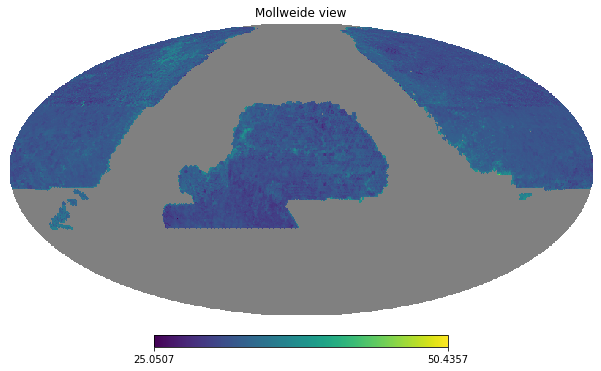

In [4]:
hp.mollview(ngal_pred)

In [5]:
# get nside from the selection function
nside = hp.get_nside(ngal_pred)
print(nside)

256


In [6]:
# normalize the selection function to [0, 1]
selection_func = normalize_selection_func(ngal_pred)

In [7]:
# subsample the mock catalog, and project to HEALPix
mock_after = downsample(selection_func, mock)
mock_hp = project2hp(nside, mock)
mock_hp_after = project2hp(nside, mock_after)

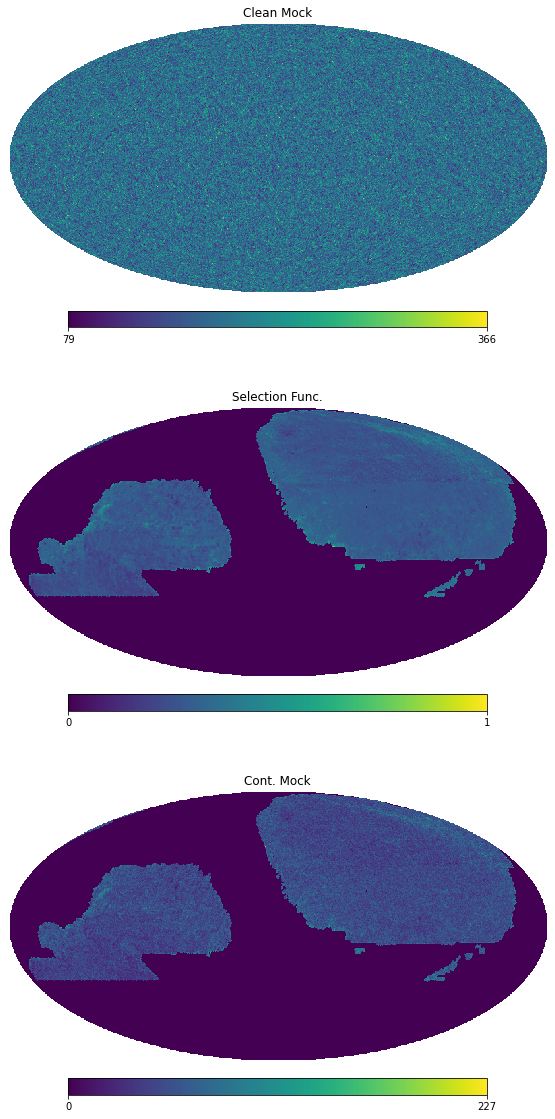

In [8]:
#
fig, ax = plt.subplots(nrows=3, figsize=(15, 20))
for i, (mapi, title) in enumerate(zip([mock_hp, selection_func, mock_hp_after],
                                      ['Clean Mock', 'Selection Func.', 'Cont. Mock'])):
    plt.sca(ax[i])        
    hp.mollview(mapi, title=title, hold=True, rot=-85)

# Power Spectrum

In [9]:
import sys
sys.path.append('/global/homes/a/arosado/LSSutils/')
#sys.path.append('/global/homes/a/arosado/LSSutils_no_mpi/')
from lssutils.stats.cl import get_cl,AnaFast
import lssutils.utils as ut
af = AnaFast()

In [10]:
def make_hp(hpix, value, nside):
    """ A Function to create a HEALPix map
    """
    m_ = np.zeros(12*nside*nside)
    m_[:] = np.nan
    m_[hpix] = value
    
    return m_

## One Contaminated Mock

In [11]:
nside=256
# subsample the mock catalog, and project to HEALPix
mock_after_hmap, hpix = project2hp(nside, mock_after, return_hpix=True)
mask = make_hp(hpix , 1.0, nside)
mask = mask > 0.5  # to make it binary

In [12]:
# collect randoms
randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
randoms, h = ft.read(randoms_path, header=True)
# keep only randoms with correct n(z) distribution (need for power spectrum measurement)
randoms = randoms[randoms['STATUS'] & 2**0 != 0]
# convert to healpix map
randoms_hmap, rand_hpix = project2hp(nside, randoms, return_hpix=True)

In [13]:
cl = get_cl(mock_after_hmap, randoms_hmap, mask)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1553c9aa1af0>
Traceback (most recent call last):
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


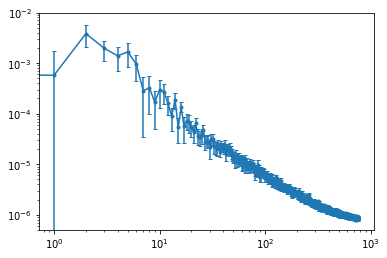

In [14]:
cl_i = cl['cl_gg']
plt.errorbar(cl_i['l'], cl_i['cl'], yerr=cl_i['cl_error'],
             marker='.', alpha=1., ls='-', capsize=2)

plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-7,1e-2)
plt.show()

## 100 contaminated mocks
we will contaminate the same mock realization with 100 different selection functions

In [15]:
from astropy.table import Table, vstack
# collect real data used to train NN
data = glob(f'/global/cscratch1/sd/arosado/nlrg_features_*_256.fits')
# stack all regions:
tables = []
for d_fn in data:
    d = Table.read(d_fn)
    #print(len(d))
    tables.append(d)
tables = vstack(tables) 

# read the mock catalog
mock_name = _desi_mock_filename(tracer='LRG', ph=0)
mock = ft.read(mock_name)

# collect randoms
randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
randoms = ft.read(randoms_path)
# keep only randoms with correct n(z) distribution (need for power spectrum measurement)
randoms = randoms[randoms['STATUS'] & 2**0 != 0]

In [16]:
from time import time
output_dir = f'/global/cscratch1/sd/arosado/test_sysnet/results/cell'

cls_dict = dict() # dictionary for storing cls

nwindows = 1000 # number of windows to pick from
only_choose = 5 # number of windows to use

np.random.seed(0)
pick_selfn_randomly = np.random.permutation(np.arange(nwindows)) # randomize selection functions to use for contamination

t0 = time()
for i, ind in enumerate(pick_selfn_randomly[:only_choose]):
    print(f'running {i+1}/{only_choose}. time elapsed: {time() - t0} s')
    # read selection function (obtained from real data)
    sel_fn = _selection_function_filename(tracer='LRG', ind=ind)
    ngal_pred = hp.read_map(sel_fn)
    
    # get nside from the selection function
    nside = hp.get_nside(ngal_pred)
    
    # normalize the selection function to [0, 1]
    selection_func = normalize_selection_func(ngal_pred)

    # subsample the mock catalog, and project to HEALPix
    mock_after = downsample(selection_func, mock)
    mock_after_hmap, hpix = project2hp(nside, mock_after, return_hpix=True)
    mask = make_hp(hpix , 1.0, nside)
    mask = mask > 0.5  # to make it binary
    
    # project randoms to healpix map
    randoms_hmap = project2hp(nside, randoms)
    cl_ = get_cl(mock_after_hmap, randoms_hmap, mask)
    cls_dict[f'nnwindow_{ind}'] = cl_
    
    # save results
    output_fn = f'{output_dir}/cell_{ind}.hp256.npy'
    print(f'saving {output_fn}')
    np.save(output_fn, cl_)
    
    
print(f'finished at {time() - t0} s')
    

running 1/5. time elapsed: 0.0002219676971435547 s


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1553c6e095e0>
Traceback (most recent call last):
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


saving /global/cscratch1/sd/arosado/test_sysnet/results/cell/cell_993.hp256.npy
running 2/5. time elapsed: 26.889602422714233 s


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1553c6974dc0>
Traceback (most recent call last):
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


saving /global/cscratch1/sd/arosado/test_sysnet/results/cell/cell_859.hp256.npy
running 3/5. time elapsed: 55.14385223388672 s


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1553c6e095e0>
Traceback (most recent call last):
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


saving /global/cscratch1/sd/arosado/test_sysnet/results/cell/cell_298.hp256.npy
running 4/5. time elapsed: 81.37830805778503 s


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1553c6974dc0>
Traceback (most recent call last):
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


saving /global/cscratch1/sd/arosado/test_sysnet/results/cell/cell_553.hp256.npy
running 5/5. time elapsed: 108.07368540763855 s


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1553c68e4040>
Traceback (most recent call last):
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


saving /global/cscratch1/sd/arosado/test_sysnet/results/cell/cell_672.hp256.npy
finished at 133.68246817588806 s


In [19]:
# get ngal, nran and mask in healpix map
ngal,nran,mask,_=read_data(tables, nside=nside)

# get cl of real data
cl_real = get_cl(ngal,nran, mask)['cl_gg']
ell_real, cell_real, cell_err = ut.histogram_cell(cl_real['l'], cl_real, return_err=True, method='jackknife')

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15551f699ee0>
Traceback (most recent call last):
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


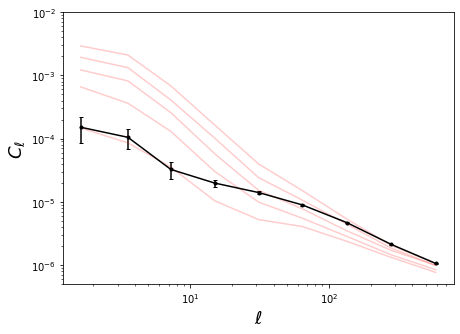

In [18]:
fig = plt.gcf()
fig.set_size_inches(7, 5)

plt.errorbar(ell_real, cell_real, yerr=cell_err, color='k',
             marker='.', alpha=1., ls='-', capsize=2)

for ind in pick_selfn_randomly[:only_choose]:
    l = cls_dict[f'nnwindow_{ind}']['cl_gg']['l']
    cl = cls_dict[f'nnwindow_{ind}']['cl_gg']
    #plt.plot(l, cl['cl'], alpha=0.2, ls='-', color='r')
    
    ell,cell,_= ut.histogram_cell(l, cl, return_err=True, method='jackknife')
    plt.plot(ell, cell, alpha=0.2, ls='-', color='r')

plt.ylabel(r'$C_{\ell}$',fontsize=18)
plt.xlabel(r'$\ell$',fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-7,1e-2)
plt.show()